# Comparação de Métodos de Geração de Sinais Sintéticos

Este notebook compara dois métodos de geração de sinais de falha em rolamentos:
1. **Método FFT (Soma de Senóides)**: Baseado no espectro de frequências calculado.
2. **Método Impulso (Resposta ao Impulso)**: Baseado na convolução de um trem de impulsos com a resposta estrutural.

O objetivo é visualizar as diferenças no domínio da frequência (FFT) para validar a qualidade dos sinais gerados.

In [33]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Adicionar src ao path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

# ... imports anteriores ...
from general_sam_analysis_utils import (
    get_mag_spectrum,
    apply_antialiasing_filter, 
    apply_hanning_window,
    limit_spectrum_frequency,
    apply_lowpass_filter   # <--- ADICIONAR
)

# Configurações Globais
RPM = 1730
FS = 12000
LOWER_FREQ_LIMIT = 0     # Hz
UPPER_FREQ_LIMIT = 800      # Hz (Filtro Passa-Baixa)
Y_MAX_AMPLITUDE  = 0.015     # Ajuste conforme necessário
SAMPLES_TO_ANALYZE = 4096   # <--- NOVO: Limite de amostras (Diminuir tamanho da FFT)

### 1. Carregar Sinal Normal Base
Usaremos um segmento real 'Normal' com 1730 RPM como ruído de fundo base para ambos os métodos.

In [34]:
normal_seg = None
for k, v in ssd.dicionario_treino.items():
    if v['rotacao_rpm'].iloc[0] == RPM:
        normal_seg = v['amplitude'].values
        print(f"Segmento Normal Carregado: {k}")
        break

# <--- NOVO: Truncar o sinal
if len(normal_seg) > SAMPLES_TO_ANALYZE:
    normal_seg = normal_seg[:SAMPLES_TO_ANALYZE]
    print(f"Sinal truncado para {SAMPLES_TO_ANALYZE} amostras.")
n = len(normal_seg)
duration = n / FS

Segmento Normal Carregado: 1730_Normal_DE_treino_seg_0


### 2. Funções Auxiliares de Plotagem

In [35]:
def plot_comparison(fault_name, sig_fft_comb, sig_impulse_comb, characteristic_freq=None, sig_real=None, f_min=LOWER_FREQ_LIMIT, f_max=UPPER_FREQ_LIMIT):
    # Truncar sinais se necessário (garantia extra)
    if 'SAMPLES_TO_ANALYZE' in globals():
        sig_fft_comb = sig_fft_comb[:SAMPLES_TO_ANALYZE]
        sig_impulse_comb = sig_impulse_comb[:SAMPLES_TO_ANALYZE]
        if sig_real is not None:
            sig_real = sig_real[:SAMPLES_TO_ANALYZE]

    # Lógica de escala Y dinâmica
    if "Esfera" in fault_name or "Ball" in fault_name:
        y_max = 0.015
    else:
        y_max = 0.015

    # Função interna para processar FFT com o novo filtro
    def calc_fft_and_process(sig):
        # 1. Filtro Passa-Baixa (NOVO)
        sig_lp = apply_lowpass_filter(sig, FS, cutoff_freq=f_max)
        
        # 2. Antialiasing (Padrão)
        sig_filt = apply_antialiasing_filter(sig_lp, FS)

        # 3. Janela de Hanning
        sig_win = apply_hanning_window(sig_filt)
        
        # 4. FFT
        yf = fft(sig_win)
        xf = fftfreq(len(sig_win), 1/FS)[:len(sig_win)//2]
        mag = 2.0/len(sig_win) * np.abs(yf[0:len(sig_win)//2])
        
        return xf, mag

    # Configuração comum de eixos para todos os subplots
    def setup_axis(ax, title):
        ax.set_title(title, fontsize=11, fontweight='bold') # +5%
        ax.set_ylabel("Magnitude", fontsize=9)             # +5%
        ax.set_xlabel("Frequência (Hz)", fontsize=9)       # +5%
        ax.set_xlim(f_min, f_max)
        ax.set_ylim(0, y_max)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=9)            # +5%

    # Plot 1: Método FFT (Figura Separada) - Achatado +5% (5.7x4)
    plt.figure(figsize=(5.7, 4), dpi=200) # Resolução melhor (200)
    x1, y1 = calc_fft_and_process(sig_fft_comb)
    plt.plot(x1, y1, color='black', alpha=0.7, label='Sinal Sintético (FFT)')
    if characteristic_freq:
        plt.axvline(x=characteristic_freq, color='red', linestyle='--', alpha=0.5, label=f'Falha: {characteristic_freq:.1f}Hz')
    setup_axis(plt.gca(), f"{fault_name} - Método de Tandon (FFT)")
    plt.tight_layout()
    plt.show()

    # Plot 2: Método Impulso (Figura Separada) - Achatado +5% (5.7x4)
    plt.figure(figsize=(5.7, 4), dpi=200)
    x2, y2 = calc_fft_and_process(sig_impulse_comb)
    plt.plot(x2, y2, color='black', alpha=0.7, label='Sinal Sintético (Impulso)')
    if characteristic_freq:
        plt.axvline(x=characteristic_freq, color='red', linestyle='--', alpha=0.5, label=f'Falha: {characteristic_freq:.1f}Hz')
    setup_axis(plt.gca(), f"{fault_name} - Método de Impulso")
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Sinal Real (Figura Separada) - Achatado +5% (5.7x4)
    if sig_real is not None:
        plt.figure(figsize=(5.7, 4), dpi=200)
        x3, y3 = calc_fft_and_process(sig_real)
        plt.plot(x3, y3, color='blue', alpha=0.7, label='Sinal Real')
        if characteristic_freq:
            plt.axvline(x=characteristic_freq, color='red', linestyle='--', alpha=0.5, label=f'Falha: {characteristic_freq:.1f}Hz')
        setup_axis(plt.gca(), f"{fault_name} - Sinal Real")
        plt.tight_layout()
        plt.show()


### 3. Geração e Comparação por Tipo de Falha

In [36]:
# Preparar geração do método de impulso para todos os tipos de uma vez
# CORREÇÃO: Criar DataFrame corretamente para evitar erro de dimensão
df_dummy = pd.DataFrame({'amplitude': normal_seg})
df_dummy['rotacao_rpm'] = RPM
df_dummy['tipo_falha'] = 'Normal'

dummy_dict = {'temp_normal': df_dummy}

print("Gerando sinais pelo método de Impulso...")
# Usamos multiplicador maior para visualizar bem o impacto
df_impulse = gid.gerar_dados_sinteticos_treino(
    dicionario_treino=dummy_dict,
    TAXA_AMOSTRAL=FS,
    params_drive_end=gid.params_drive_end,
    amplitudes_referencia=gid.amplitudes_referencia,
    multiplicadores=[1], # Amplitude x1 (Realista)
    fases_para_adicionar_rad=[0]
)

Gerando sinais pelo método de Impulso...
Gerando Sinais com impulsos delta de Dirac puros...
Geração concluída. Total de 4 segmentos de treino.


Buscando sinal real: RPM=1730, Tipo=Pista Externa, Diam=0.014"
Sinal ENCONTRADO! Chave: 1730_OR@6_14_DE_seg_0, Tam: 4096
Plotando comparativo... Real Sig: Presente


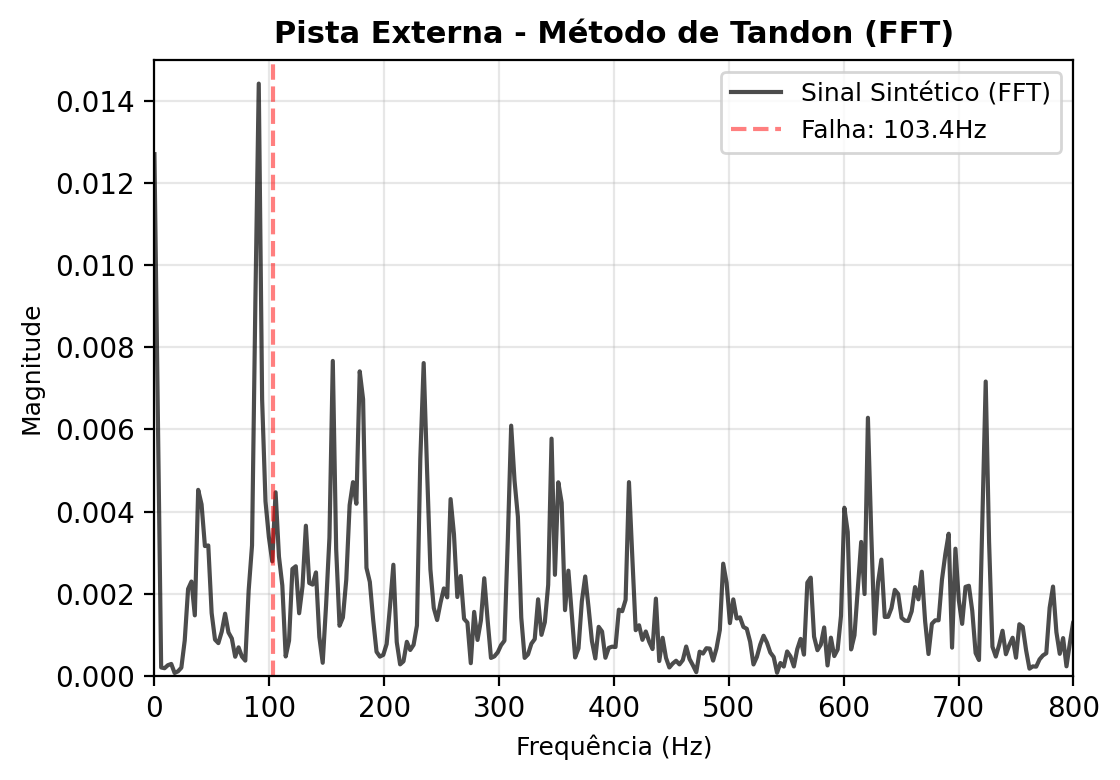

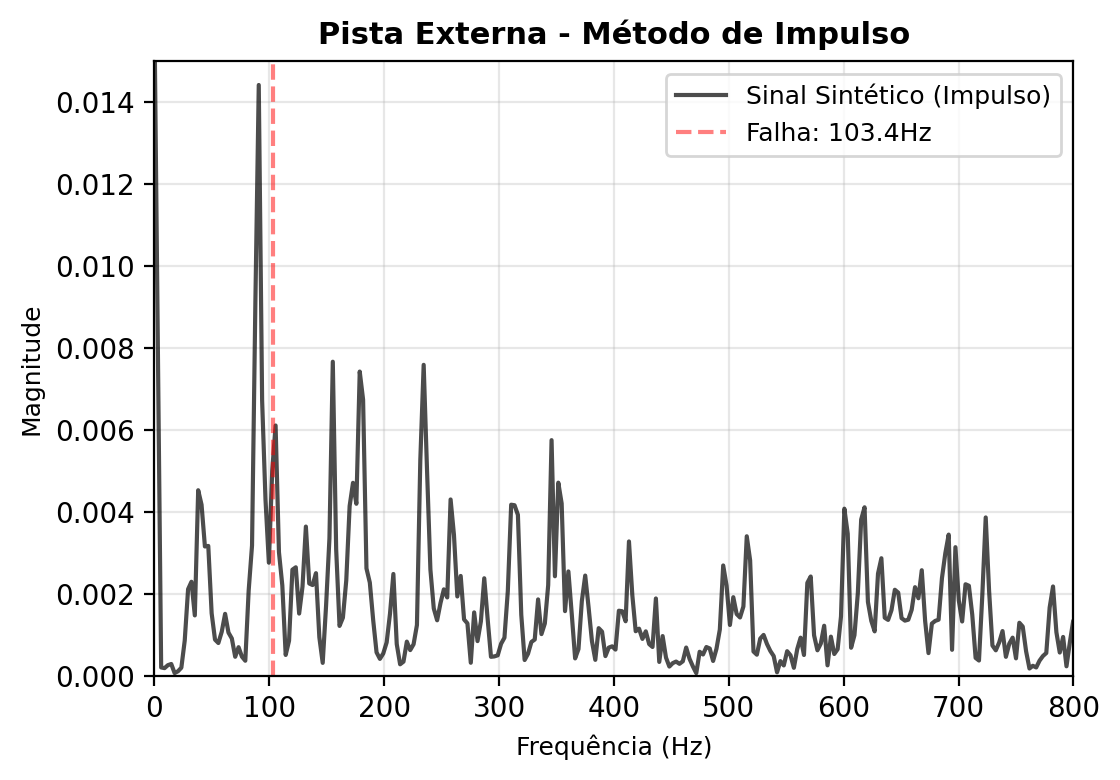

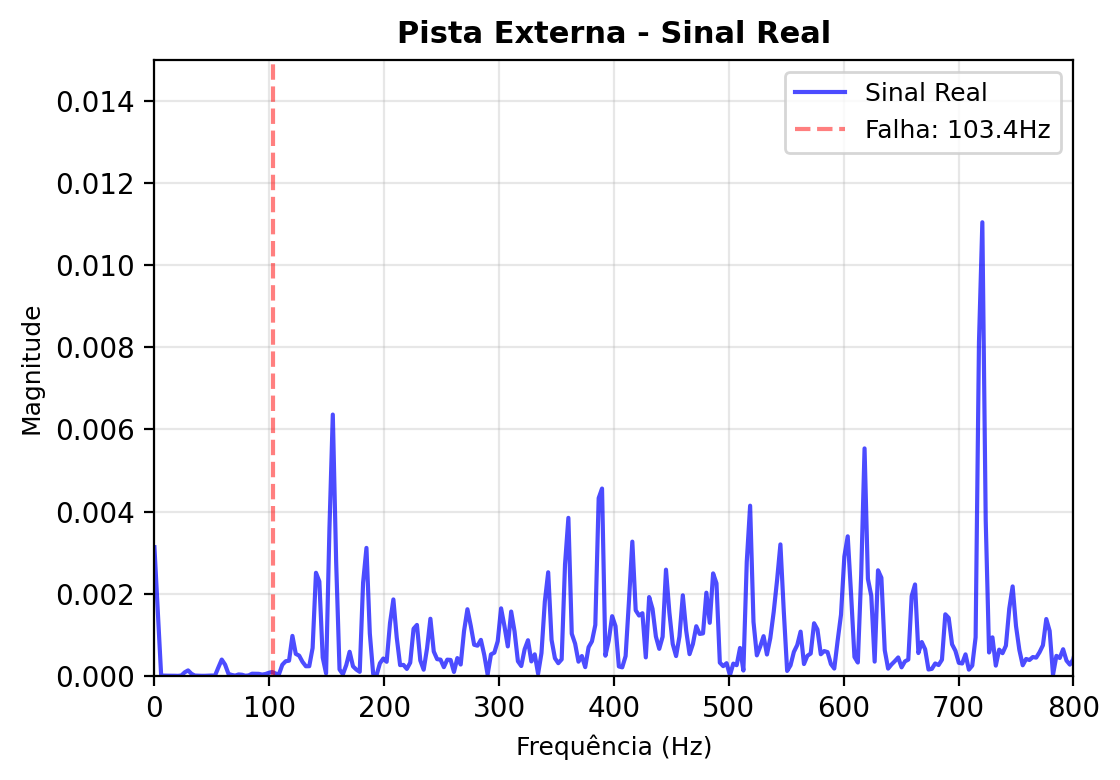

In [37]:
# --- Pista Externa ---

# 1. Gerar FFT Method
spec_outer = bu.calcular_espectro_outer_race(fault_diameter_mm=0.3556, rpm=1730, K=0.02) # Ajuste K para ficar comparável se necessário
sig_outer_gen = gsd.synthesize_time_signal(spec_outer, duration=duration, fs=FS)
# Ajuste de tamanho
sig_outer_gen = sig_outer_gen[:n] if len(sig_outer_gen) > n else np.pad(sig_outer_gen, (0, n - len(sig_outer_gen)))
final_outer_fft = normal_seg + sig_outer_gen

# 2. Pegar Impulse Method
row_outer = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Pista Externa'].iloc[0]
final_outer_imp = row_outer['sinal_final']
final_outer_imp_pure = row_outer['sinal_puro']

# Calculate char freq
coeffs_out = bu.calculate_tandon_coefficients(fault_diameter_mm=0.3556, rpm=1730, fault_type='outer')
freq_out = coeffs_out['frequencies']['defect_freq_hz']


# 3. Pegar Real Signal
real_sig = None
target_diam = '0.014"'
target_fault = 'Pista Externa'
target_rpm = RPM

print(f"Buscando sinal real: RPM={target_rpm}, Tipo={target_fault}, Diam={target_diam}")

for key, df_seg in ssd.dicionario_teste.items():
    try:
        # Casting para evitar erros de tipos (numpy int vs int, etc)
        meta_rpm = int(df_seg['rotacao_rpm'].iloc[0])
        meta_type = str(df_seg['tipo_falha'].iloc[0])
        meta_diam = str(df_seg['diametro_falha'].iloc[0])
        
        if meta_rpm == int(target_rpm) and meta_type == target_fault and meta_diam == target_diam:
            real_sig = df_seg['amplitude'].values
            print(f"Sinal ENCONTRADO! Chave: {key}, Tam: {len(real_sig)}")
            
            # Adjust size
            if len(real_sig) < n:
                 real_sig = np.pad(real_sig, (0, n - len(real_sig)))
            else:
                 real_sig = real_sig[:n]
            break
    except Exception as e:
        continue

if real_sig is None:
    print(f"AVISO: Sinal real NÃO encontrado no dicionário!")

print(f"Plotando comparativo... Real Sig: {'None' if real_sig is None else 'Presente'}")
plot_comparison("Pista Externa", final_outer_fft, final_outer_imp, characteristic_freq=freq_out, sig_real=real_sig)

Buscando sinal real: RPM=1730, Tipo=Pista Interna, Diam=0.014"
Sinal ENCONTRADO! Chave: 1730_IR_14_DE_seg_0, Tam: 4096
Plotando comparativo... Real Sig: Presente


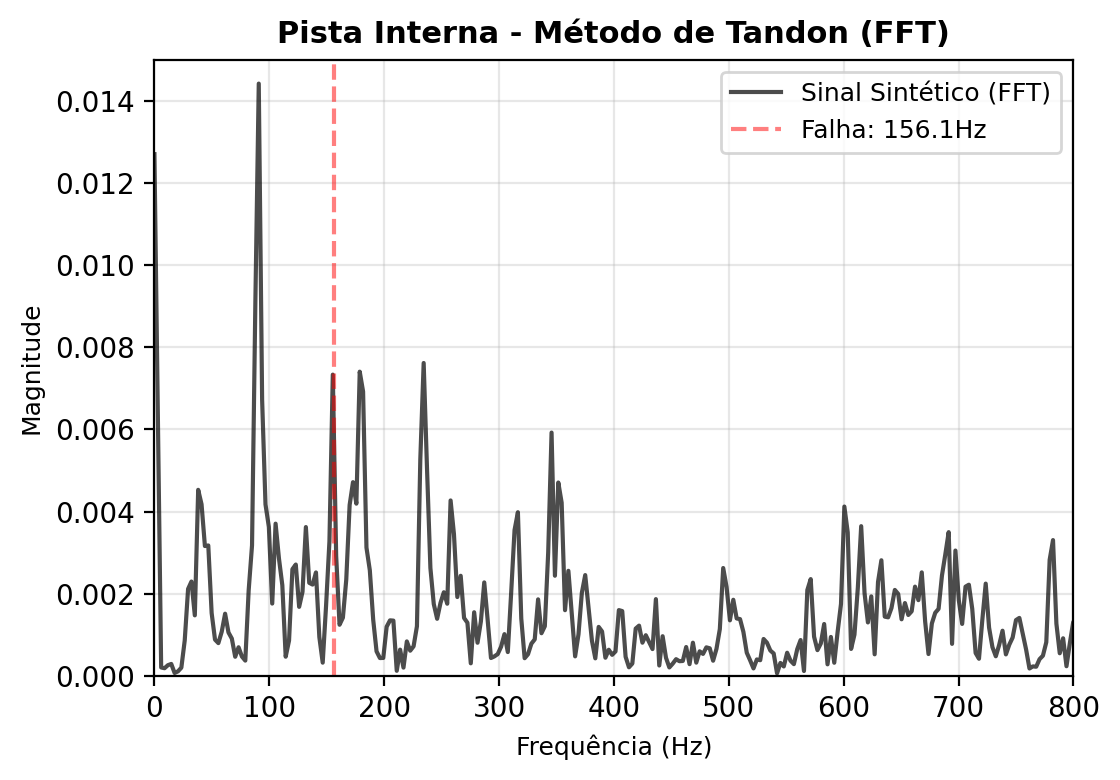

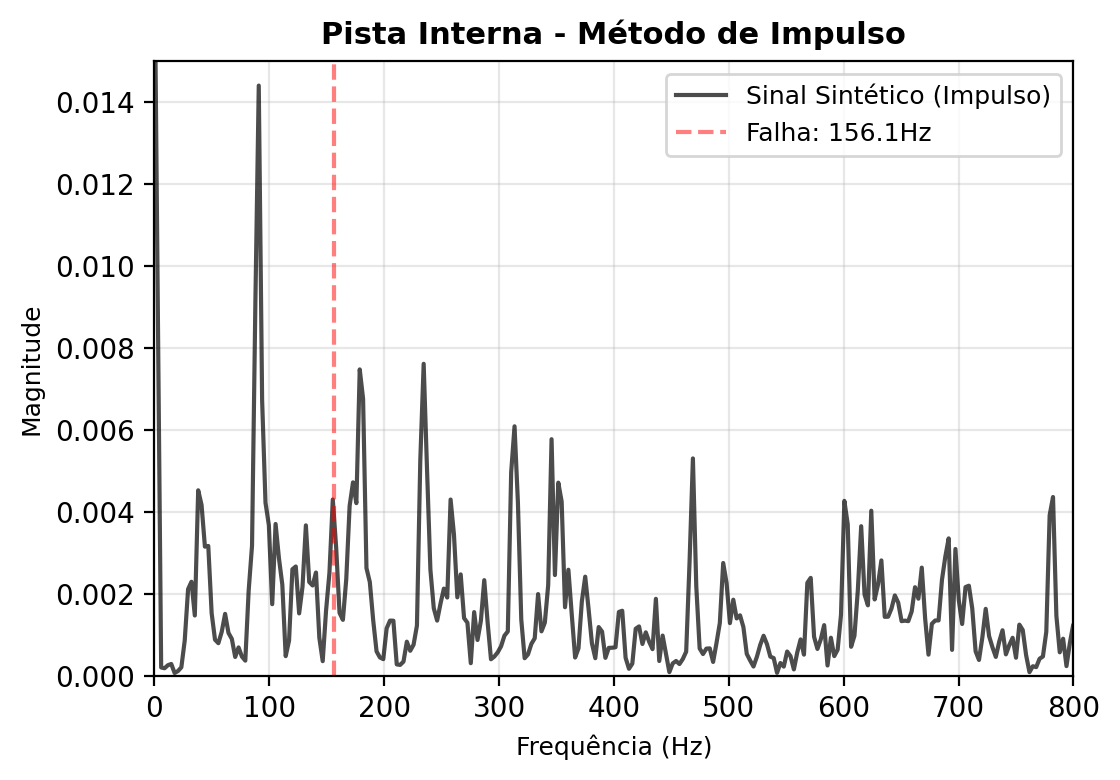

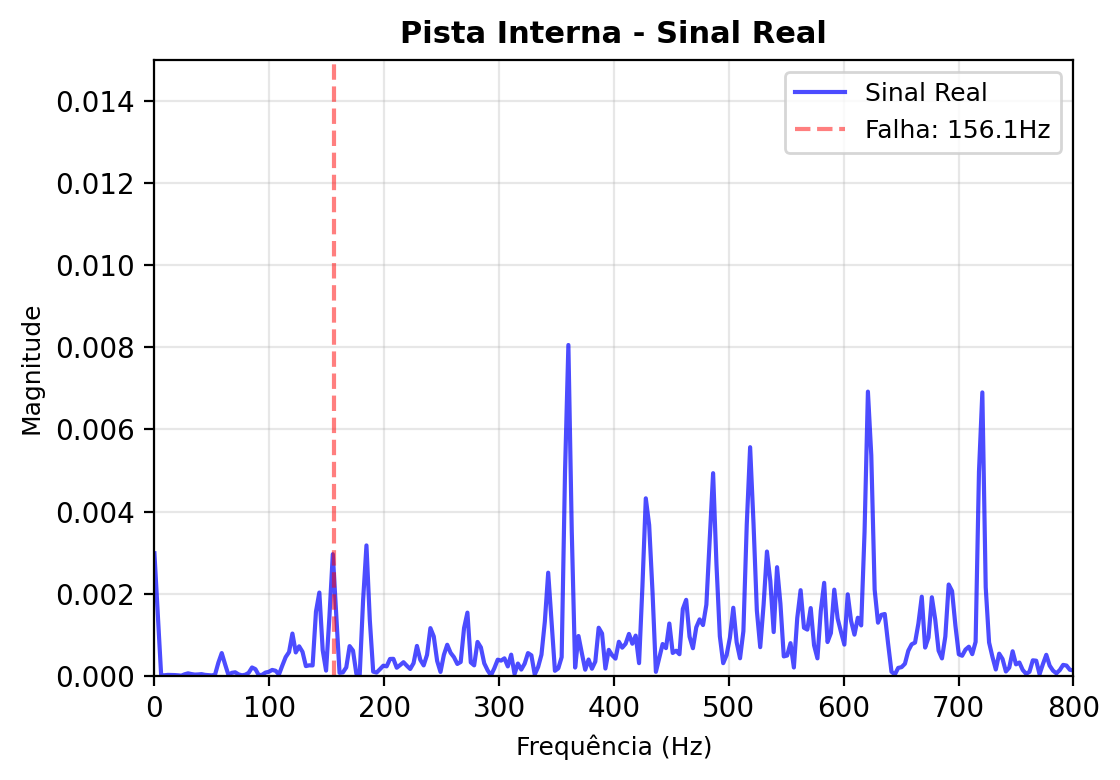

In [38]:
# --- Pista Interna ---

# 1. Gerar FFT Method
spec_inner = bu.calcular_espectro_inner_completo(fault_diameter_mm=0.3556, rpm=1730, K=0.05)
sig_inner_gen = gsd.synthesize_time_signal(spec_inner, duration=duration, fs=FS)
sig_inner_gen = sig_inner_gen[:n] if len(sig_inner_gen) > n else np.pad(sig_inner_gen, (0, n - len(sig_inner_gen)))
final_inner_fft = normal_seg + sig_inner_gen

# 2. Pegar Impulse Method
row_inner = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Pista Interna'].iloc[0]
final_inner_imp = row_inner['sinal_final']
final_inner_imp_pure = row_inner['sinal_puro']

# Calculate char freq
coeffs_in = bu.calculate_tandon_coefficients(fault_diameter_mm=0.3556, rpm=1730, fault_type='inner')
freq_in = coeffs_in['frequencies']['defect_freq_hz']


# 3. Pegar Real Signal
real_sig = None
target_diam = '0.014"'
target_fault = 'Pista Interna'
target_rpm = RPM

print(f"Buscando sinal real: RPM={target_rpm}, Tipo={target_fault}, Diam={target_diam}")

for key, df_seg in ssd.dicionario_teste.items():
    try:
        # Casting para evitar erros de tipos (numpy int vs int, etc)
        meta_rpm = int(df_seg['rotacao_rpm'].iloc[0])
        meta_type = str(df_seg['tipo_falha'].iloc[0])
        meta_diam = str(df_seg['diametro_falha'].iloc[0])
        
        if meta_rpm == int(target_rpm) and meta_type == target_fault and meta_diam == target_diam:
            real_sig = df_seg['amplitude'].values
            print(f"Sinal ENCONTRADO! Chave: {key}, Tam: {len(real_sig)}")
            
            # Adjust size
            if len(real_sig) < n:
                 real_sig = np.pad(real_sig, (0, n - len(real_sig)))
            else:
                 real_sig = real_sig[:n]
            break
    except Exception as e:
        continue

if real_sig is None:
    print(f"AVISO: Sinal real NÃO encontrado no dicionário!")

print(f"Plotando comparativo... Real Sig: {'None' if real_sig is None else 'Presente'}")
plot_comparison("Pista Interna", final_inner_fft, final_inner_imp, characteristic_freq=freq_in, sig_real=real_sig)

Buscando sinal real: RPM=1730, Tipo=Esfera, Diam=0.021"
Sinal ENCONTRADO! Chave: 1730_B_21_DE_seg_0, Tam: 4096
Plotando comparativo... Real Sig: Presente


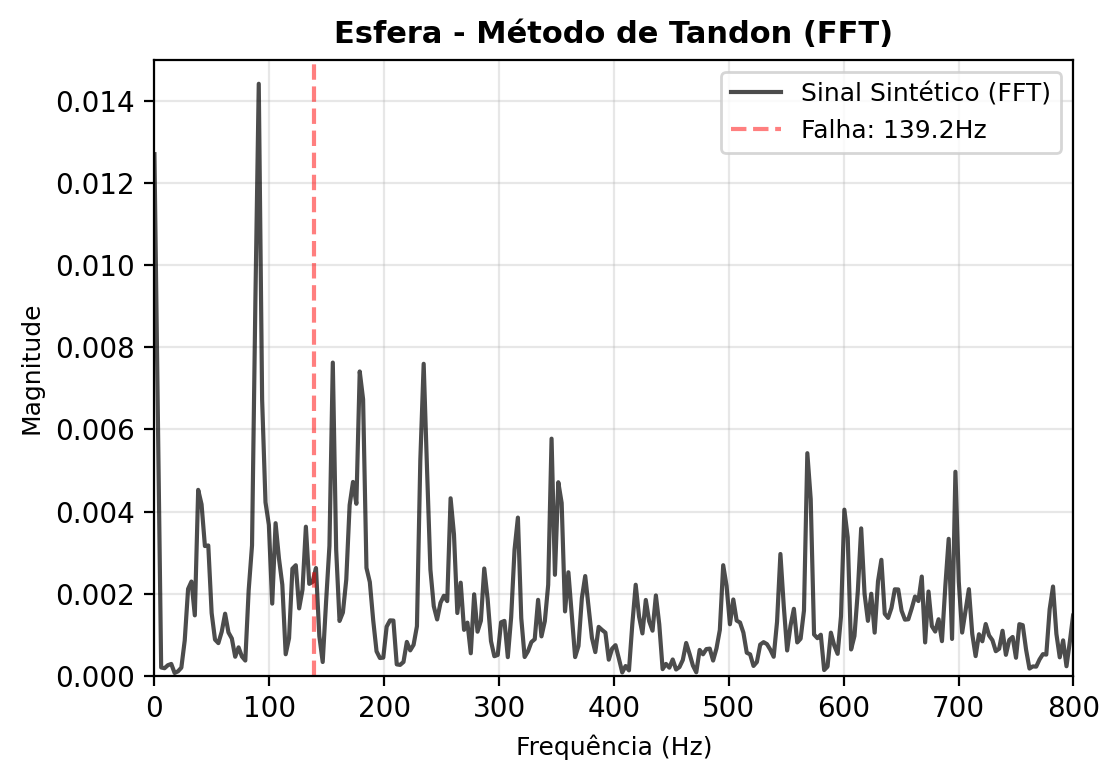

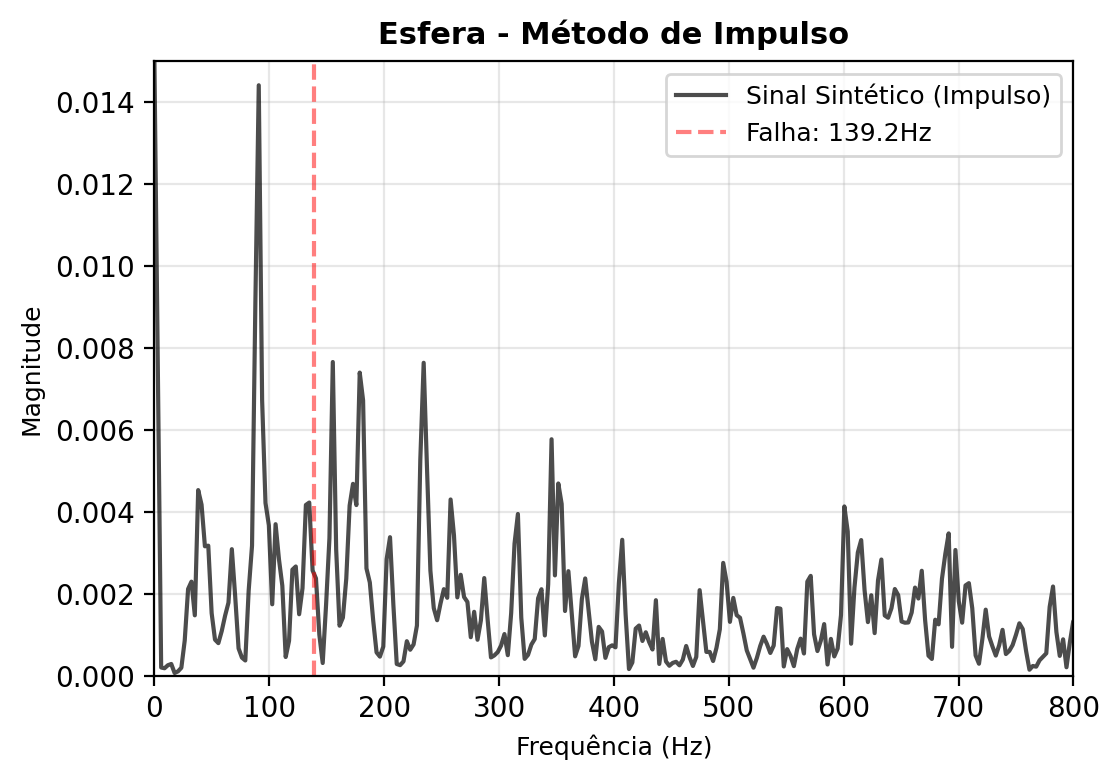

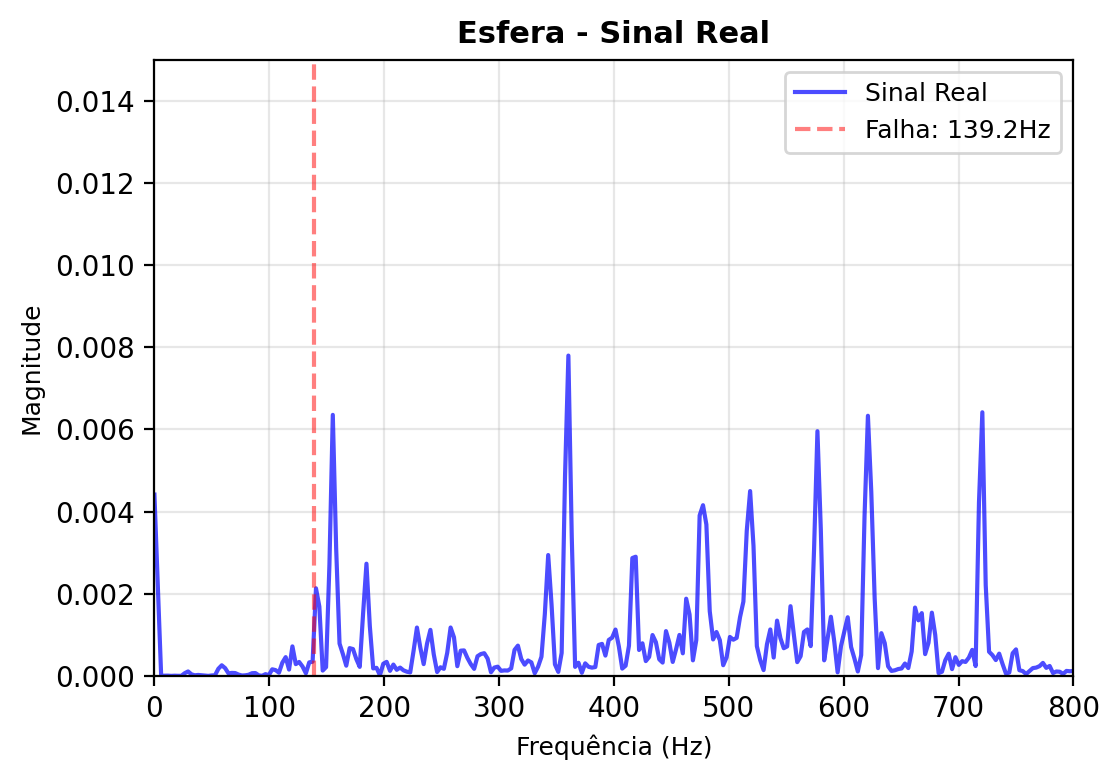

In [39]:
# --- Esfera ---

# 1. Gerar FFT Method
spec_ball = bu.calcular_espectro_ball_completo(fault_diameter_mm=0.5334, rpm=1772, K=0.02)
sig_ball_gen = gsd.synthesize_time_signal(spec_ball, duration=duration, fs=FS)
sig_ball_gen = sig_ball_gen[:n] if len(sig_ball_gen) > n else np.pad(sig_ball_gen, (0, n - len(sig_ball_gen)))
final_ball_fft = normal_seg + sig_ball_gen

# 2. Pegar Impulse Method
row_ball = df_impulse[df_impulse['tipo_falha_adicionada'] == 'Esfera'].iloc[0]
final_ball_imp = row_ball['sinal_final']
final_ball_imp_pure = row_ball['sinal_puro']

# Calculate char freq
coeffs_ball = bu.calculate_tandon_coefficients(fault_diameter_mm=0.5334, rpm=1772, fault_type='ball')
freq_ball = coeffs_ball['frequencies']['defect_freq_hz']


# 3. Pegar Real Signal
real_sig = None
target_diam = '0.021"'
target_fault = 'Esfera'
target_rpm = RPM

print(f"Buscando sinal real: RPM={target_rpm}, Tipo={target_fault}, Diam={target_diam}")

for key, df_seg in ssd.dicionario_teste.items():
    try:
        # Casting para evitar erros de tipos (numpy int vs int, etc)
        meta_rpm = int(df_seg['rotacao_rpm'].iloc[0])
        meta_type = str(df_seg['tipo_falha'].iloc[0])
        meta_diam = str(df_seg['diametro_falha'].iloc[0])
        
        if meta_rpm == int(target_rpm) and meta_type == target_fault and meta_diam == target_diam:
            real_sig = df_seg['amplitude'].values
            print(f"Sinal ENCONTRADO! Chave: {key}, Tam: {len(real_sig)}")
            
            # Adjust size
            if len(real_sig) < n:
                 real_sig = np.pad(real_sig, (0, n - len(real_sig)))
            else:
                 real_sig = real_sig[:n]
            break
    except Exception as e:
        continue

if real_sig is None:
    print(f"AVISO: Sinal real NÃO encontrado no dicionário!")

print(f"Plotando comparativo... Real Sig: {'None' if real_sig is None else 'Presente'}")
plot_comparison("Esfera", final_ball_fft, final_ball_imp, characteristic_freq=freq_ball, sig_real=real_sig)